
# Replace RNN model with biL-STM model and biGRU model

Comparison between the models : 
+ (+)RNNs process data in a sequential manner (one direction); they retain information from previous steps but can struggle to remember distant information due to issues like vanishing gradients.
- (-)RNNs fail to capture long-term dependencies, especially in long sequences, as the information fades over time, and gradients vanish during backpropagation through time. Limits effectiveness in tasks requiring model to remember information over many time steps.
-----------------------------------------------
- (+)BiLSTM : Bidirectional Long Short-Term Memory, a RNN, handle long term dependencies better. It has gates that help regulate flow of information, enabling them to retain or discard information as needed.

- BiLSTM consists of 2 LSTM layers running in opposite directions : 1 processes sequence from past to future, while other processes it from future to past : captures both past and future context for each time step 

- BiLSTM helps to capture context from both directions, beneficial in tasks where understanding context of each word is important

- (-) BiLSTMs are computationally more intensive than regular LSTMs and RNNs due to bidirectional component and complexity of gating mechanism
-----------------------------------------------
- (+)BiGRU, type of RNN, has 2 gates instead of 3 used by LSTMS - makes GRUs faster to computer while still handling long-term dependencies better than traditional RNNs. Includes 2 GRU layers, one running forward one running backward, learnign both past and present context. 

- BiGRUs achieve similar performance to BiLSTMs but with fewer parameters and faster computation, making them more efficient for large datasets 

- (-)Although GRUs generally simpler and faster, might be less expressive in certain cases due to absence of output gate




In [1]:
!pip install -r requirements.txt

In [2]:
from datasets import load_dataset
from utils.rnn_model import *
from utils.rnn_utils import *
from dotenv import load_dotenv
import os

load_dotenv()

c:\Users\pushp\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
c:\Users\pushp\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\pushp\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\pushp\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\pushp\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


False

In [3]:
dataset = load_dataset("rotten_tomatoes")
trn_dataset = dataset["train"]
val_dataset = dataset["validation"]
tst_dataset = dataset["test"]

README.md:   0%|          | 0.00/7.46k [00:00<?, ?B/s]

c:\Users\pushp\anaconda3\lib\site-packages\huggingface_hub\file_download.py:139: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\pushp\.cache\huggingface\hub\datasets--rotten_tomatoes. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


train.parquet:   0%|          | 0.00/699k [00:00<?, ?B/s]

validation.parquet:   0%|          | 0.00/90.0k [00:00<?, ?B/s]

test.parquet:   0%|          | 0.00/92.2k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/8530 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1066 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1066 [00:00<?, ? examples/s]

In [5]:
word2vec_model = load_word2vec()


[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [6]:
word_index = {
    word: i for i, word in enumerate(
        word2vec_model.index_to_key
    )
}

In [7]:
trn_sentences, trn_labels = prepare_data(
    trn_dataset["text"],
    trn_dataset["label"],
    word_index=word_index
)
val_sentences, val_labels = prepare_data(
    val_dataset["text"],
    val_dataset["label"],
    word_index=word_index
)
tst_sentences, tst_labels = prepare_data(
    tst_dataset["text"],
    tst_dataset["label"],
    word_index=word_index
)

# biL-STM model

In [8]:

BATCH_SIZE = 32
LR = 0.0001
MODEL_TYPE = "lstm"

In [12]:
trn_dataloader = create_dataloader(
    trn_sentences,
    trn_labels,
    BATCH_SIZE,
    shuffle=True)
val_dataloader = create_dataloader(
    val_sentences,
    val_labels,
    BATCH_SIZE,
    shuffle=False)
tst_dataloader = create_dataloader(
    tst_sentences,
    tst_labels,
    BATCH_SIZE,
    shuffle=False)

In [9]:
# initialize BiLSTM model with both directions and multiple layers
model = RNNModel(
    embedding_dim=300,
    hidden_size=256,
    embedding_matrix=word2vec_model.vectors,
    rnn_type=MODEL_TYPE,       # alr set to "lstm" for BiLSTM
    bidirectional=True,        # enable bidirectionality
    num_layers=2               # set to 2 for stacking multiple layers
)

In [14]:
# training with max pooling over the BiLSTM outputs
train(
    model=model,
    trn_dataloader=trn_dataloader,
    val_dataloader=val_dataloader,
    version="1",
    model_type=MODEL_TYPE,
    model_save_path=os.getenv("MODEL_SAVE_PATH", "modelfiles/"),
    optimizer=torch.optim.Adam(model.parameters(), lr=LR),
    epochs=100,
    early_stopping_patience=10,
    train_mode="max_pool"      # use max_pool for training
)

Epoch   1/100, Loss: 0.5111, Accuracy: 0.7589
Model saved.
Epoch   2/100, Loss: 0.4887, Accuracy: 0.7486
Epoch   3/100, Loss: 0.4731, Accuracy: 0.7561
Epoch   4/100, Loss: 0.4597, Accuracy: 0.7439
Epoch   5/100, Loss: 0.4552, Accuracy: 0.7523
Epoch   6/100, Loss: 0.4439, Accuracy: 0.7561
Epoch   7/100, Loss: 0.4370, Accuracy: 0.7542
Epoch   8/100, Loss: 0.4268, Accuracy: 0.7542
Epoch   9/100, Loss: 0.4181, Accuracy: 0.7533
Epoch  10/100, Loss: 0.4090, Accuracy: 0.7505
Epoch  11/100, Loss: 0.3999, Accuracy: 0.7570
Early stopping triggered after 11 epochs.
Training ended, loading best model...
Model loaded.


Accuracy: 0.7627
Epoch   1/100, Loss: 0.4859, Accuracy: 0.7627
Model saved.
Accuracy: 0.7711
Epoch   2/100, Loss: 0.4716, Accuracy: 0.7711
Model saved.
Accuracy: 0.7383
Epoch   3/100, Loss: 0.4654, Accuracy: 0.7383
Accuracy: 0.7542
Epoch   4/100, Loss: 0.4548, Accuracy: 0.7542
Accuracy: 0.7580
Epoch   5/100, Loss: 0.4456, Accuracy: 0.7580
Accuracy: 0.7636
Epoch   6/100, Loss: 0.4364, Accuracy: 0.7636
Accuracy: 0.7645
Epoch   7/100, Loss: 0.4297, Accuracy: 0.7645
Accuracy: 0.7542
Epoch   8/100, Loss: 0.4229, Accuracy: 0.7542
Accuracy: 0.7561
Epoch   9/100, Loss: 0.4160, Accuracy: 0.7561
Accuracy: 0.7477
Epoch  10/100, Loss: 0.4156, Accuracy: 0.7477
Accuracy: 0.7402
Epoch  11/100, Loss: 0.4014, Accuracy: 0.7402
Accuracy: 0.7533
Epoch  12/100, Loss: 0.3938, Accuracy: 0.7533
Early stopping triggered after 12 epochs.
Training ended, loading best model...
Model loaded.


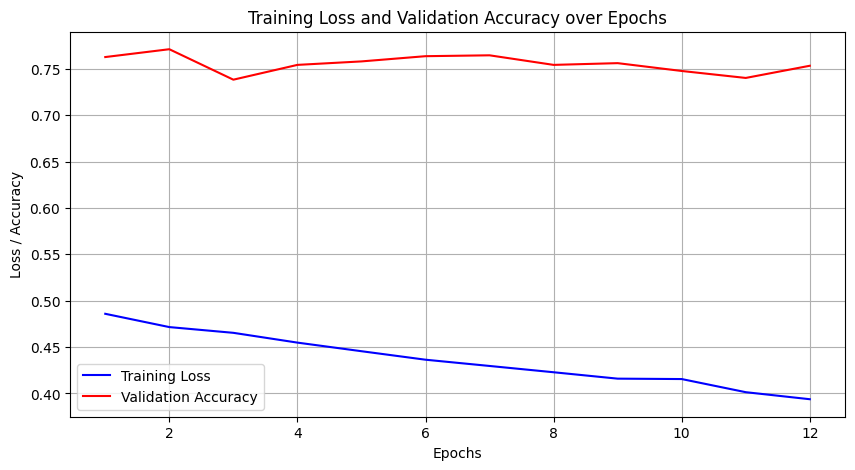

In [15]:
# Training and plotting results with the BiLSTM model
train_and_plot(
    model=model,
    trn_dataloader=trn_dataloader,
    val_dataloader=val_dataloader,
    version="1",
    model_type=MODEL_TYPE,
    model_save_path=os.getenv("MODEL_SAVE_PATH", "modelfiles/"),
    optimizer=torch.optim.Adam(model.parameters(), lr=LR),
    epochs=100,
    early_stopping_patience=10,
    train_mode="max_pool"      # use max_pool for training
)

In [16]:
# Validate the BiLSTM model on validation and test datasets
val_accuracy = validate(model, val_dataloader)

Accuracy: 0.7711


In [17]:
tst_accuracy = validate(model, tst_dataloader)

Accuracy: 0.7439


Trying with an increased number of stack layers

In [ ]:
# initialize BiLSTM model with both directions and multiple layers
model = RNNModel(
    embedding_dim=300,
    hidden_size=256,
    embedding_matrix=word2vec_model.vectors,
    rnn_type=MODEL_TYPE,       # alr set to "lstm" for BiLSTM
    bidirectional=True,        # enable bidirectionality
    num_layers=4               # increased to 4 for stacking multiple layers
)

Accuracy: 0.7083
Epoch   1/100, Loss: 0.6086, Accuracy: 0.7083
Model saved.
Accuracy: 0.7542
Epoch   2/100, Loss: 0.5097, Accuracy: 0.7542
Model saved.
Accuracy: 0.7589
Epoch   3/100, Loss: 0.4845, Accuracy: 0.7589
Model saved.
Accuracy: 0.7505
Epoch   4/100, Loss: 0.4706, Accuracy: 0.7505
Accuracy: 0.7580
Epoch   5/100, Loss: 0.4590, Accuracy: 0.7580
Accuracy: 0.7552
Epoch   6/100, Loss: 0.4545, Accuracy: 0.7552
Accuracy: 0.7683
Epoch   7/100, Loss: 0.4476, Accuracy: 0.7683
Model saved.
Accuracy: 0.7580
Epoch   8/100, Loss: 0.4350, Accuracy: 0.7580
Accuracy: 0.7523
Epoch   9/100, Loss: 0.4278, Accuracy: 0.7523
Accuracy: 0.7627
Epoch  10/100, Loss: 0.4211, Accuracy: 0.7627
Accuracy: 0.7345
Epoch  11/100, Loss: 0.4072, Accuracy: 0.7345
Accuracy: 0.7355
Epoch  12/100, Loss: 0.4005, Accuracy: 0.7355
Accuracy: 0.7495
Epoch  13/100, Loss: 0.3922, Accuracy: 0.7495
Accuracy: 0.7448
Epoch  14/100, Loss: 0.3819, Accuracy: 0.7448
Accuracy: 0.7542
Epoch  15/100, Loss: 0.3741, Accuracy: 0.7542
Acc

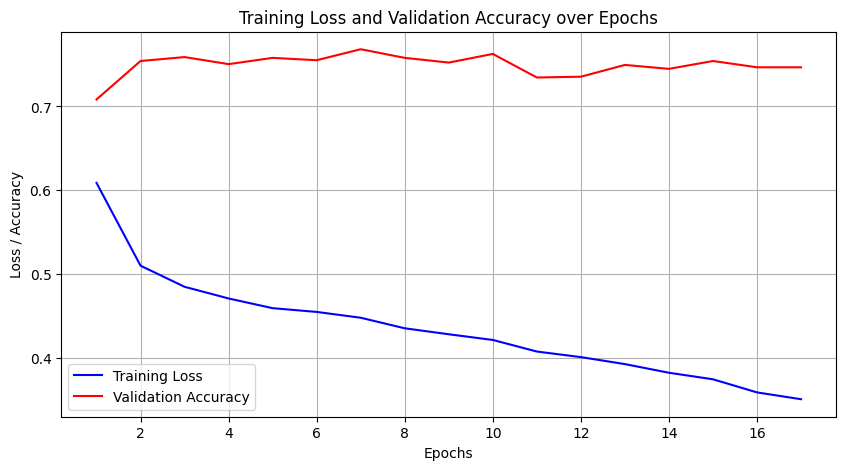

In [19]:
# Training and plotting results with the BiLSTM model
train_and_plot(
    model=model,
    trn_dataloader=trn_dataloader,
    val_dataloader=val_dataloader,
    version="1",
    model_type=MODEL_TYPE,
    model_save_path=os.getenv("MODEL_SAVE_PATH", "modelfiles/"),
    optimizer=torch.optim.Adam(model.parameters(), lr=LR),
    epochs=100,
    early_stopping_patience=10,
    train_mode="max_pool"      # use max_pool for training
)

In [20]:
# Validate the BiLSTM model on validation and test datasets
val_accuracy = validate(model, val_dataloader)

Accuracy: 0.7683


In [21]:
tst_accuracy = validate(model, tst_dataloader)

Accuracy: 0.7477


# biGRU model